# Heston Optimization

In [2]:
import numpy as np

from data.data_processor.data_processor import ModelPriceProcessor, MarketPriceProcessor
from calc_engine.calibration.error_functions import sum_of_squares, sum_of_squares_heston
from calc_engine.option_pricing.option_price_factory import OptionPriceFactory
from utils.util_funcs import get_stock_price

ImportError: cannot import name 'sum_of_squares_heston' from 'calc_engine.calibration.error_functions' (c:\Users\dibia\OneDrive\Documents\Projects\Beta\py_op_beta\calc_engine\calibration\error_functions.py)

In [ ]:
ticker = 'SPY'
close_date = '2025-01-02'
S = get_stock_price(ticker, close_date)
mark_proc = MarketPriceProcessor(ticker, close_date)
heston_fft = OptionPriceFactory().create_model('heston', 'fft')
model_proc = ModelPriceProcessor(heston_fft)

print(mark_proc.option_call_graph.get_expirations())

exps = ['2025-01-31', '2025-03-31', '2025-06-30', '2025-09-30', '2025-12-31', '2026-06-18']
dtes = []

for exp in exps:
    dtes.append(mark_proc.option_call_graph.get_dte_from_str(exp))

dtes = np.array(dtes) / 365

market_data = mark_proc.put_call_price_surface(S, 500, 630, exps)

market_strikes = [np.array([strikes for strikes, _ in row]) for row in market_data]
market_prices = [np.array([price for _, price in row]) for row in market_data]

model_data = model_proc.put_call_price_surface(S, market_strikes, dtes, sigma = .3, v0 = .06, theta = .05, kappa = 2.5, rho = -.8)

model_strikes = [np.array([strikes for strikes, _ in row]) for row in model_data]
model_prices = [np.array([price for _, price in row]) for row in model_data]

dict_keys(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07', '2025-02-21', '2025-02-28', '2025-03-21', '2025-03-31', '2025-04-17', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-08-15', '2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15'])


In [ ]:
for i in range(len(market_prices)):
    print(i)
    print('-----------------------------')
    print(f"len market strikes: {len(market_strikes[i])}")
    print(f"len model strikes: {len(model_strikes[i])}")
    print('-----------------------------')

0
-----------------------------
len market strikes: 128
len model strikes: 128
-----------------------------
1
-----------------------------
len market strikes: 103
len model strikes: 103
-----------------------------
2
-----------------------------
len market strikes: 84
len model strikes: 84
-----------------------------
3
-----------------------------
len market strikes: 96
len model strikes: 96
-----------------------------
4
-----------------------------
len market strikes: 42
len model strikes: 42
-----------------------------
5
-----------------------------
len market strikes: 28
len model strikes: 28
-----------------------------


In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

def error_function_processor_bridge_heston(S, strikes, market_prices, T, model, **kwargs) -> float:
    data = ModelPriceProcessor(model).put_call_price_surface(S, strikes, T, **kwargs)
    model_strikes = [np.array([strikes for strikes, _ in row]) for row in data]
    model_prices = [np.array([price for _, price in row]) for row in data]
    #st.write(f"model prices: {model_prices}")
    #st.write(f"model strikes: {model_strikes}")
    #print(f"---------------------------------------------------------------")
    #print(f"model strikes: {strikes}")
    #print(f"market strikes: {model_strikes}")
    #print(f"---------------------------------------------------------------")
    sse = normalized_root_mean_squared_error(market_prices, model_prices)
    print(f"sse: {sse}")
    return sse

def normalized_root_mean_squared_error(market_prices, model_prices) -> float:
    nrmse_list = [np.sqrt(np.mean(((market_price - model_price) / (market_price + 1e-8)) ** 2)) for market_price, model_price in zip(market_prices, model_prices)]
    return np.sum(nrmse_list)

def root_mean_squared_error(market_prices, model_prices) -> float:
    rmse_list = [np.sqrt(np.mean((market_price - model_price) ** 2)) for market_price, model_price in zip(market_prices, model_prices)]
    return np.sum(rmse_list)

class HestonOptimizer:
    """
    We could not get this to properly optimize in the future I will have to vectorize the price surface
    """
    def __init__(self, model, error_function = normalized_root_mean_squared_error):
        self.model = model
        self.error_function = error_function
    
    def optimize(self, S: float, strikes: list[float], prices: list[list[float]], T: list[float], r: float = 0, q: float = 0, guess=[0.3, .06, .05, 2.5, -.8], bounds=((1e-2, None), (1e-3, None), (1e-3, None), (1e-3, None), (-.95, .95)), method='SLSQP', tol=1e-15):
        """
        Optimize the parameters of the CEV model using Scipy minimize.
        bounds=((1e-6, None), (1e-6, None), (1e-6, None), (-.95, .95))
        bounds=((1e-2, 1), (1e-3, 0.1), (1e-3, 0.1), (1e-3, 5), (-.95, .95))
        bounds=((1e-6, 1), (1e-6, .1), (1e-6, 5), (-.95, .95))
        """
        #opt_func = lambda x: self.error_function(S, strikes, prices, T, self.model, sigma=x[0], v0 = x[1], theta = x[2], kappa = x[3], rho = x[4], r=r, q = q) 

        def opt_func(x):
            sigma, v0, theta, kappa, rho = x

            # Feller condition: 2 * kappa * theta > sigma^2
            # Penalize Feller condition violations
            if 2 * kappa * theta <= sigma**2:
                return np.inf

            return self.error_function(S, strikes, prices, T, self.model,
                                    sigma=sigma, v0=v0, theta=theta,
                                    kappa=kappa, rho=rho, r=r, q=q)
        result = minimize(opt_func, guess, bounds=bounds, method=method, tol=tol)
        print(result)
        params = result.x 
        return params

In [ ]:
heston = OptionPriceFactory().create_model('heston', 'fft')

hest_opt = HestonOptimizer(heston, error_function_processor_bridge_heston)

In [ ]:
lbfgsb = 'L-BFGS-B'
powell = 'Powell'
slsqp = "SLSQP"
nelder_mead = 'Nelder-Mead'
met = ["SLSQP", "BFGS", "L-BFGS-B", "TNC", "Nelder-Mead", "Powell", "trust-constr"]

hest_opt.optimize(S, market_strikes, market_prices, dtes, method = 'SLSQP')

sse: 7.89987938997923
sse: 7.899879338268578
sse: 7.899881911685786
sse: 7.899880397168898
sse: 7.899879388048157
sse: 7.899879404396727
sse: 7.642668661173387
sse: 7.642668607657161
sse: 7.64267118010515
sse: 7.642669669618218
sse: 7.64266865941716
sse: 7.642668677548166
sse: 6.902272077645982
sse: 6.902272018538355
sse: 6.902274562591796
sse: 6.902273078789285
sse: 6.902272076811838
sse: 6.90227210361156
sse: 6.901951913788949
sse: 6.901951854679839
sse: 6.901954398705881
sse: 6.9019529149256345
sse: 6.901951912955179
sse: 6.901951939759368
sse: 6.901942838782459
sse: 6.901942779673347
sse: 6.90194532369848
sse: 6.901943839919014
sse: 6.901942837948704
sse: 6.901942864753075
sse: 6.901935305882202
sse: 6.901935246772996
sse: 6.901937790797359
sse: 6.901936307018491
sse: 6.901935305048515
sse: 6.90193533185291
sse: 6.90189878294427
sse: 6.901898723834994
sse: 6.901901267854565
sse: 6.90189978407958
sse: 6.901898782110734
sse: 6.901898808915933
 message: Singular matrix E in LSQ subpro

array([ 0.4945261 ,  0.05882621,  0.04902545,  2.49364941, -0.80298515])

## Optimization Notes:
##### Using normalized relative mean squared error with SLSQP seems to perform the best so far, there are two ways we can doe this
##### 1. return using np.sum in the objective function
##### 2. Return using np.mean in the error function
##### Both 1 and 2 work well
##### Nelder Mead with normalized relative mean squared error also works well using np.sum

In [ ]:
error_function_processor_bridge_heston(S, market_strikes, market_prices, dtes, heston_fft, sigma = .3, v0 = .06, theta = .04, kappa = 2.5, rho = -.9)

np.float64(27332.041326734714)

## Heston Optimization part 2.

In [1]:
import numpy as np

from calc_engine.calibration.model_optimization import HestonOptimizer
from calc_engine.option_pricing.option_price_factory import OptionPriceFactory
from data.data_processor.data_processor import MarketPriceProcessor
from data.data_processor.adapters import ErrorFunctionAdapter
from utils.util_funcs import get_stock_price

In [2]:
ticker = "SPY"
close_date = "2024-08-01"

S = get_stock_price(ticker, close_date)
min_strike, max_strike = 450, 600

exps = ['2024-08-30', '2024-10-31', '2024-12-31', '2025-03-31', '2025-06-30', '2026-06-18']
dtes = []

market_processor = MarketPriceProcessor(ticker, close_date)

for exp in exps:
    dte = market_processor.option_call_graph.get_dte_from_str(exp)
    dtes.append(dte)

dtes = np.array(dtes) / 252

market_data = market_processor.put_call_price_surface(S, min_strike, max_strike, exps)
#print(f"Expirations: {market_processor.option_call_graph.get_expirations()}")
market_strikes = [np.array([strikes for strikes, _ in row]) for row in market_data]
market_prices = [np.array([price for _, price in row]) for row in market_data]

In [ ]:
heston_error_function = ErrorFunctionAdapter().heston
model = OptionPriceFactory().create_model('heston', 'fft')
heston_optimizer = HestonOptimizer(model, heston_error_function)

In [4]:
params = heston_optimizer.optimize(S, market_strikes, market_prices, dtes)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.0168033095754563
       x: [ 2.613e-01  2.195e-02  1.636e-02  2.292e+00 -5.262e-01]
     nit: 16
     jac: [-7.480e-01 -8.026e+00  1.289e+01 -9.826e-03 -7.804e-02]
    nfev: 117
    njev: 15


In [20]:
params

array([ 0.26128538,  0.02194802,  0.01636487,  2.29235423, -0.52619792])

In [5]:
def func(**kwargs):
    if "optimization_flag" in kwargs:
        print(True)

    for k, v in kwargs.items():

        print(f"k: {k}")
        print(f"v: {v}")

func(j = 10, l = 90, go = 48, optimization_flag=True)

True
k: j
v: 10
k: l
v: 90
k: go
v: 48
k: optimization_flag
v: True


## Optimization SABR

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_processor.model_data_processor import ModelPriceProcessor
from data_processor.market_data_processor import MarketPriceProcessor 
from calc_engine.calibration.error_functions import sum_of_squares, sum_of_squares_heston
from calc_engine.option_pricing.option_price_factory import OptionPriceFactory
from calc_engine.volatility.iv_calc import ImpliedVolatility
from utils.util_funcs import get_stock_price

In [ ]:
ticker = 'SPY'
close_date = '2025-05-22'
S = get_stock_price(ticker, close_date)
mark_proc = MarketPriceProcessor(ticker, close_date)
sabr_an = OptionPriceFactory().create_model('SABR', 'analytical')
model_proc = ModelPriceProcessor(sabr_an)
iv_root_calc = ImpliedVolatility()

print(mark_proc.option_call_graph.get_expirations())

exps = ['2025-06-30','2025-09-30', '2025-12-31', '2026-06-18', '2027-01-15']

dtes = [mark_proc.option_call_graph.get_dte_from_str(exp) / 252 for exp in exps]

market_data = mark_proc.put_call_price_surface(S, 500, 640, exps, steps=10)

market_strikes = [np.array([strikes for strikes, _ in row]) for row in market_data]
market_prices = [np.array([price for _, price in row]) for row in market_data]
market_ivs = [
    np.array([
        iv_root_calc.root_finder(
            price, S, strike, dte, otype='call' if strike > S else 'put'
        )
        for strike, price in row
    ])
    for row, dte in zip(market_data, dtes)
]

dtes = np.array(dtes)

dict_keys(['2025-05-22', '2025-05-23', '2025-05-27', '2025-05-28', '2025-05-29', '2025-05-30', '2025-06-06', '2025-06-13', '2025-06-20', '2025-06-27', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17'])


In [ ]:
def error_function_processor_bridge_sabr(S: float, strikes: list[float], market_ivs: list[float], T: float, model, **kwargs):
    model_ivs = np.array(model.lognormal_vol(S, strikes, T, **kwargs))
    sse = sum_of_squares(market_ivs, model_ivs)
    return sse

def normalized_root_mean_squared_error(market_prices, model_prices) -> float:
    nrmse_list = [np.sqrt(np.mean(((market_price - model_price) / (market_price + 1e-8)) ** 2)) for market_price, model_price in zip(market_prices, model_prices)]
    return np.sum(nrmse_list)

def root_mean_squared_error(market_prices, model_prices) -> float:
    rmse_list = [np.sqrt(np.mean((market_price - model_price) ** 2)) for market_price, model_price in zip(market_prices, model_prices)]
    return np.sum(rmse_list)

class SABROptimizer:
    """
    This is a very simple way to optimize sabr, later we will make this faster by using the method from the SABR paper we read.
    """
    
    def __init__(self, model: str, error_function = error_function_processor_bridge_sabr):
        self.model = model
        self.error_function = error_function

    def manual_optimizer(self, S: float, strikes: list[float], ivs: list[float], T: float, beta: float=.99):
        alpha_list = np.linspace(.01, 5, 30) #[.1, .2, .4, .6, .8] 
        rho_list = np.linspace(-.99, .99, 30) #[-.5, -.2, .2, .5, .8]
        sigma_list = np.linspace(.01, .8, 30) #[.1, .25, .4, .5, .65]

        sse_list = []
        for i in range(len(alpha_list)):
            for j in range(len(sigma_list)):
                for k in range(len(rho_list)):
                    sse = self.error_function(S, strikes, ivs, T, self.model, self.calculation_type, sigma_0=sigma_list[j], alpha=alpha_list[i], beta=beta, rho=rho_list[k])
                    sse_list.append((sse, sigma_list[j], alpha_list[i], rho_list[k]))

        min_params = min(sse_list)

        return [min_params[1], min_params[2], min_params[3]]
    
    def optimize(self, S: float, strikes: list[float], ivs: list[float], T: float, beta: float = .5, guess=[.3, .5, -.2], bounds=((0.001, None), (0.001, None), (-0.95, 0.95)), method='SLSQP', tol=1e-10):
        opt_func = lambda x: self.error_function(S, strikes, ivs, T, self.model, sigma_0=x[0], alpha=x[1], beta = beta, rho=x[2])
        result = minimize(opt_func, guess, bounds=bounds, method=method, tol=tol)
        params = result.x
        return params

In [ ]:
sabr_opt = SABROptimizer(sabr_an)

sabr_param_df = pd.DataFrame()
sabr_param_df["sigma_0"] = np.zeros(len(market_ivs))
sabr_param_df["alpha"] = np.zeros(len(market_ivs))
sabr_param_df["rho"] = np.zeros(len(market_ivs))

for i in range(len(market_ivs)):
    params = sabr_opt.optimize(S, market_strikes[i], market_ivs[i], dtes[i], method = 'Nelder-Mead', tol=1e-10)
    print(params)
    sabr_param_df["sigma_0"].iloc[i] = params[0]
    sabr_param_df["alpha"].iloc[i] = params[1]
    sabr_param_df["rho"].iloc[i] = params[2]

sabr_param_df

[ 3.49369433  1.87852252 -0.8069656 ]
[ 3.88261824  1.29868875 -0.94566814]
[ 4.08046085  1.28644624 -0.95      ]
[ 3.61608649  1.82275538 -0.82739451]
[10.67088501 10.86701704 -0.80884952]


C:\Users\dibia\AppData\Local\Temp\ipykernel_8036\4188222370.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sabr_param_df["sigma_0"].iloc[i] = params[0]
C:\Users\dibia\AppData\Local\Temp\ipykernel_8036\4188222370.py:12: FutureWarning: C

,sigma_0,alpha,rho
0,3.493694,1.878523,-0.806966
1,3.882618,1.298689,-0.945668
2,4.080461,1.286446,-0.950000
3,3.616086,1.822755,-0.827395
4,10.670885,10.867017,-0.808850


In [ ]:
skew_data = model_proc.put_call_price_skew(S, market_strikes[3], dtes[3], sigma_0 = 3.8826, alpha = 1.878523, beta = .5, rho = -.8069, r = .04, q = 0)
strikes, _ = zip(*skew_data)

True
True


In [ ]:
sabr_ivs = sabr_an.lognormal_vol(S, market_strikes[3], dtes[3], sigma_0 = 3.8826, alpha = 1.878523, beta = .5, rho = -.8069)
market_ivs = [iv_root_calc.root_finder(price, S, strike, dtes[1], otype='call' if strike > S else 'put') for strike, price in skew_data]

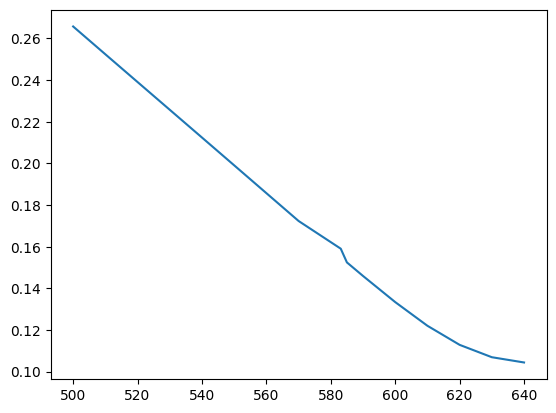

In [ ]:
plt.plot(strikes, sabr_ivs)

## Optimizing Rough Bergomi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from data_processor.model_data_processor import ModelPriceProcessor
from data_processor.market_data_processor import MarketPriceProcessor 
from calc_engine.calibration.error_functions import sum_of_squares, sum_of_squares_puts_and_calls
from calc_engine.option_pricing.option_price_factory import OptionPriceFactory
from calc_engine.volatility.iv_calc import ImpliedVolatility
from utils.util_funcs import get_stock_price

In [ ]:
ticker = 'SPY'
close_date = '2025-05-22'
S = get_stock_price(ticker, close_date)
mark_proc = MarketPriceProcessor(ticker, close_date)
rbergomi_sim = OptionPriceFactory().create_model('Rough Bergomi', 'sim')
model_proc = ModelPriceProcessor(rbergomi_sim)
iv_root_calc = ImpliedVolatility()

print(mark_proc.option_call_graph.get_expirations())

exps = ['2025-06-30','2025-09-30', '2025-12-31', '2026-06-18', '2027-01-15']

dtes = [mark_proc.option_call_graph.get_dte_from_str(exp) / 252 for exp in exps]

market_data = mark_proc.put_call_price_surface(S, 500, 640, exps, steps=10)

market_strikes = [np.array([strikes for strikes, _ in row]) for row in market_data]
market_prices = [np.array([price for _, price in row]) for row in market_data]

dict_keys(['2025-05-22', '2025-05-23', '2025-05-27', '2025-05-28', '2025-05-29', '2025-05-30', '2025-06-06', '2025-06-13', '2025-06-20', '2025-06-27', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17'])


In [ ]:
def sum_of_squares_puts_and_calls(S: float, strikes: np.ndarray, market_prices: np.ndarray, T: float, model, **kwargs) -> float:

    assert len(strikes) == len(market_prices), "Strikes and market prices must be the same length"

    put_indices = np.where(strikes <= S)[0]
    call_indices = np.where(strikes > S)[0]

    market_call = market_prices[call_indices]
    market_put = market_prices[put_indices]

    call_strikes = strikes[call_indices]
    put_strikes = strikes[put_indices]

    model_call = model.call(S, call_strikes, T, **kwargs)
    sum_call = np.sum((market_call - model_call)**2)
    
    model_put = model.put(S, put_strikes, T, **kwargs)
    sum_put = np.sum((market_put - model_put)**2)

    return sum_call + sum_put

def error_function_processor_bridge(S, strikes, market_prices, T, model, **kwargs) -> float:
    model_strikes, model_prices = zip(*ModelPriceProcessor(model).put_call_price_skew(S, strikes, T, **kwargs))
    sse = sum_of_squares(market_prices, model_prices)
    return sse

class rBergomiOptimizer:
    
    def __init__(self, model: str, error_function = sum_of_squares_puts_and_calls):
        self.model = model
        self.error_function = error_function

    def manual_optimizer(self, S: float, strikes: list[float], prices: list[float], T: float, xi: float):
        a_list = np.linspace(-.49, .49, 30) #[.1, .2, .4, .6, .8] 
        rho_list = np.linspace(-.99, .99, 30) #[-.5, -.2, .2, .5, .8]
        eta_list = np.linspace(.01, 5, 30) #[.1, .25, .4, .5, .65]

        sse_list = []
        for i in range(len(a_list)):
            for j in range(len(rho_list)):
                for k in range(len(eta_list)):
                    sse = self.error_function(S, strikes, prices, T, self.model, self.calculation_type, xi = xi, a=a_list[j], rho=rho_list[i], eta=eta_list[k])
                    sse_list.append((sse, a_list[j], rho_list[i], eta_list[k]))

        min_params = min(sse_list)

        return [min_params[1], min_params[2], min_params[3]]
    
    def optimize(self, S: float, strikes: np.ndarray, prices: np.ndarray, T: float, guess=[.055, -.4, -.9, 1.9], bounds=((.01, .14), (-.49, .49), (-.9, .9), (.01, 5)), method='SLSQP', tol=1e-10):
        opt_func = lambda x: self.error_function(S, strikes, prices, T, self.model, xi = x[0], a=x[1], rho=x[2], eta = x[3])
        result = minimize(opt_func, guess, bounds=bounds, method=method, tol=tol)
        params = result.x
        return params

In [ ]:
dtes[1]

0.5198412698412699

In [ ]:
rbergomi_sim.call(S, market_strikes[1], dtes[1], xi = .055, a = -.4, rho=-.8, eta = 1.9)

array([79.04696929, 70.8249946 , 62.95955731, 55.52732702, 48.4025982 ,
       41.71870469, 35.56223541, 29.94415996, 24.83818987, 23.41471801,
       20.29748309, 16.35537322, 13.08878415, 10.34519803,  7.96883962,
        6.01588996])

In [ ]:
sum_of_squares_puts_and_calls(S, market_strikes[1], market_prices[1], dtes[1], rbergomi_sim, xi = .055, a = -.4, rho=-.8, eta = 1.9)

np.float64(210.02256666861683)

In [ ]:
rbergomi_opt = rBergomiOptimizer(rbergomi_sim)
rbergomi_opt.optimize(S, market_strikes[1], market_prices[1], dtes[1], method="Nelder-Mead", tol=1e-3)

array([ 0.05474194, -0.38923626, -0.9       ,  2.03206776])

In [ ]:
rbergomi_opt = rBergomiOptimizer(rbergomi_sim, error_function_processor_bridge)
rbergomi_opt.optimize(S, market_strikes[1], market_prices[1], dtes[1], method="Nelder-Mead", tol=1e-3)

array([ 0.05587707, -0.38713115, -0.9       ,  2.18345573])

In [ ]:
type(market_prices[1])

numpy.ndarray

## rBergomi Optimizer part 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from calc_engine.calibration.model_optimization import rBergomiOptimizer
from calc_engine.option_pricing.option_price_factory import OptionPriceFactory
from data.data_processor.data_processor import MarketPriceProcessor, ModelPriceProcessor, VolatilityProcessor
from data.data_processor.adapters import ErrorFunctionAdapter
from utils.util_funcs import get_stock_price

ticker = "SPY"
close_date = "2024-08-01"

S = get_stock_price(ticker, close_date)
min_strike, max_strike = 450, 600

#exps = ['2024-08-30', '2024-10-31', '2024-12-31', '2025-03-31', '2025-06-30', '2026-06-18']
dtes = []
exp = '2025-03-31'
market_processor = MarketPriceProcessor(ticker, close_date)

#for exp in exps:
dte = market_processor.option_call_graph.get_dte_from_str(exp) / 252
    #dtes.append(dte)

#dtes = np.array(dtes) / 252

#market_data = market_processor.put_call_price_surface(S, min_strike, max_strike, exps)
market_strikes, market_prices = zip(*market_processor.put_call_price_skew(S, 420, 610, exp, steps=10))
market_strikes, market_prices = np.array(market_strikes), np.array(market_prices)
#print(f"Expirations: {market_processor.option_call_graph.get_expirations()}")
#market_strikes = [np.array([strikes for strikes, _ in row]) for row in market_data]
#market_prices = [np.array([price for _, price in row]) for row in market_data]

rbergomi_error_function = ErrorFunctionAdapter().rbergomi
model = OptionPriceFactory().create_model('rbergomi', 'sim')
rbergomi_optimizer = rBergomiOptimizer(model, rbergomi_error_function)
params = rbergomi_optimizer.optimize(S, market_strikes, market_prices, dte, method = 'Powell')

In [6]:
params

array([ 0.05278398, -0.32369291, -0.47507765,  1.79477041])

In [7]:
rbergomi_model = ModelPriceProcessor(model)
strikes, prices = zip(*rbergomi_model.put_call_price_skew(S, market_strikes, dte, xi = params[0], a = params[1], rho = params[2], eta = params[3]))
strikes, ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, prices, market_strikes, dte))

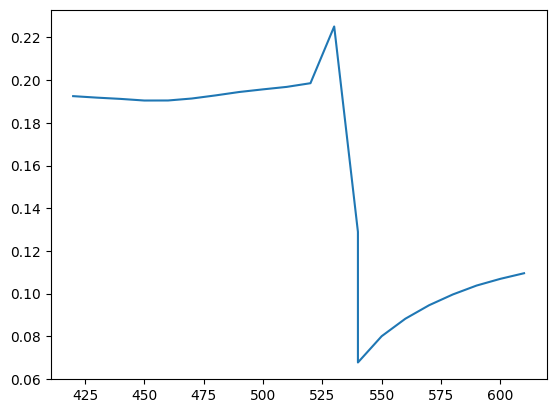

In [8]:
plt.plot(strikes, ivs)

In [24]:
print(f"len strikes: {len(strikes)}")
print(f"prices: {prices}")
print(f"len ivs: {len(ivs)}")
ivs

len strikes: 90
prices: (1.7848829559822068, 1.8404465774571752, 1.9010205782385616, 1.9656311168385001, 2.035318146199218, 2.1067888740034166, 2.1813174184886686, 2.2588450974344907, 2.3385613727471664, 2.421399776848111, 2.5049998397495195, 2.5895378886130413, 2.6767567571124764, 2.7667578698021336, 2.857797717015637, 2.951502641513505, 3.0485974711659662, 3.1487343697768684, 3.251881763158667, 3.3585036097278924, 3.4698603203239067, 3.582891650752804, 3.6981967517537346, 3.819955340856508, 3.9466391613958005, 4.077139096448773, 4.2109125714319475, 4.34624876164787, 4.483752753162038, 4.6231148293064335, 4.766076197926498, 4.9123387188383925, 5.062443946844712, 5.218917586114612, 5.379496169368115, 5.543216759400608, 5.711635969169647, 5.886732116159791, 6.065904469630198, 6.252127645090159, 6.446419538733965, 6.646251937472704, 6.84923864663634, 7.05567646937695, 7.2672215411039, 7.486353294653884, 7.713115351017723, 7.946162004832417, 8.183319299597995, 8.427350486350424, 8.6780304

(np.float64(0.17512955216637063),
 np.float64(0.17481766395571138),
 np.float64(0.17457849317504326),
 np.float64(0.174386833032714),
 np.float64(0.17425928201124663),
 np.float64(0.17412711993397567),
 np.float64(0.1740138804292273),
 np.float64(0.17391639852204846),
 np.float64(0.17381821784108464),
 np.float64(0.1737350160391775),
 np.float64(0.17362440495059558),
 np.float64(0.17349036618294802),
 np.float64(0.17336236311708408),
 np.float64(0.17324092335239105),
 np.float64(0.17309739040605798),
 np.float64(0.1729575664964447),
 np.float64(0.1728315164342766),
 np.float64(0.17271256084758668),
 np.float64(0.172599134955877),
 np.float64(0.17249685036510387),
 np.float64(0.17242199289861937),
 np.float64(0.17233037894241773),
 np.float64(0.1722303683743036),
 np.float64(0.17217687234547152),
 np.float64(0.17214685995792625),
 np.float64(0.17212430815702773),
 np.float64(0.1721014260129595),
 np.float64(0.17205673513143632),
 np.float64(0.17199807275213824),
 np.float64(0.1719219507

In [25]:
prac_strikes, prac_prices = zip(*rbergomi_model.put_call_price_skew(S, market_strikes[2], dtes[2], xi = .055, a = -.4, rho = -.8, eta = 1.5))
strikes, ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, prac_prices, prac_strikes, dtes[2]))

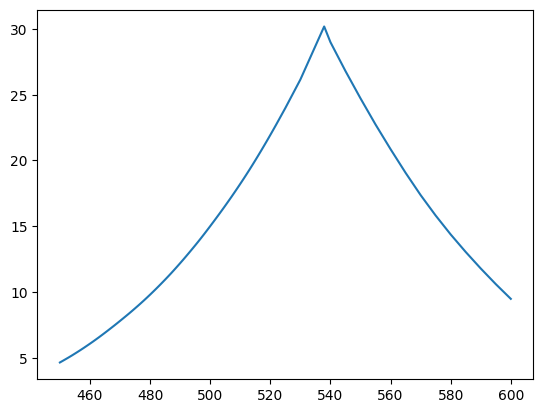

In [28]:
plt.plot(prac_strikes, prac_prices)

## Time series data

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import time
import numpy as np

from calc_engine.volatility.iv_calc import ImpliedVolatility
from data.data_processor.data_processor import MarketPriceProcessor, VolatilityProcessor
from calc_engine.greeks.analytical_greeks import AnalyticalDelta
from data.price_data import process_price_data
from data.option_data.process_option_chain import OptionFactory
from utils import date_utils
from utils.util_funcs import get_stock_price

In [13]:
ticker = 'SPY'
close_date = '2024-03-15'
option_exp = '1M'
S = get_stock_price(ticker, close_date)

market_proc = MarketPriceProcessor(ticker, close_date)

start = '2024-03-15'
end = "2024-04-15"

exp = market_proc.option_call_graph.get_expirations_from_int(option_exp)
dte = market_proc.option_call_graph.get_dte_from_str(exp)

strikes, prices = zip(*market_proc.put_call_price_skew(S, 450, 550, exp))

In [40]:
def delta_skew(put_delta, call_delta, ticker, start, end, option_exp = '1M'):
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]
    skew_list = []
    for close_date in common_dates:

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]
        min_strike, max_strike = S*.9, S*1.1
        
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp = market_proc.option_call_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_call_graph.get_dte_from_str(exp)/252

        strikes, prices = zip(*market_proc.put_call_price_skew(S, min_strike, max_strike, exp))
        strikes, prices = np.array(strikes), np.array(prices)
        #print(f"put indices: {np.where(strikes < S)[0]}")
        #print(f"prices: {prices}")
        #strikes, ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, prices, strikes, dte))
        call_strikes, call_ivs = zip(*VolatilityProcessor().otm_call_ivs(S, prices, strikes, dte))
        put_strikes, put_ivs = zip(*VolatilityProcessor().otm_put_ivs(S, prices, strikes, dte))
        call_ivs, put_ivs = np.array(call_ivs), np.array(put_ivs)
        #print(f"len ivs: {len(ivs)}")
        #print(f"len strikes: {len(strikes)}")
        call_deltas = AnalyticalDelta().calculate(S, call_strikes, dte, call_ivs, otype='call')
        put_deltas = AnalyticalDelta().calculate(S, put_strikes, dte, put_ivs, otype='put')
        call_idx = np.abs(call_deltas - call_delta).argmin()
        call_delta_iv = call_ivs[call_idx]
        print(f"call deltas: {call_deltas}")
        #print(f"call strikes: {call_strikes}")
        print(f"put deltas: {put_deltas}")
        put_idx = np.abs(put_deltas - put_delta).argmin()
        put_delta_iv = put_ivs[put_idx]
        #print(f"put strikes: {put_strikes}")
        #plt.plot(call_strikes, call_deltas)
        #plt.show()
        skew = put_delta_iv - call_delta_iv
        print('-'*100)
        print(f"put delta iv: {put_delta_iv}")
        print(f"call delta iv: {call_delta_iv}")
        print(f"skew: {skew}")
        skew_list.append((close_date, skew))
    return skew_list

def normalized_delta_skew(put_delta, call_delta, ticker, start, end, option_exp = '1M'):
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]
    skew_list = []
    for close_date in common_dates:

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]
        min_strike, max_strike = S*.9, S*1.1
        
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp = market_proc.option_call_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_call_graph.get_dte_from_str(exp)/252

        strikes, prices = zip(*market_proc.put_call_price_skew(S, min_strike, max_strike, exp))
        strikes, prices = np.array(strikes), np.array(prices)
        #print(f"put indices: {np.where(strikes < S)[0]}")
        #print(f"prices: {prices}")
        #strikes, ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, prices, strikes, dte))
        call_strikes, call_ivs = zip(*VolatilityProcessor().otm_call_ivs(S, prices, strikes, dte))
        put_strikes, put_ivs = zip(*VolatilityProcessor().otm_put_ivs(S, prices, strikes, dte))
        call_ivs, put_ivs = np.array(call_ivs), np.array(put_ivs)
        #print(f"len ivs: {len(ivs)}")
        #print(f"len strikes: {len(strikes)}")
        call_deltas = AnalyticalDelta().calculate(S, call_strikes, dte, call_ivs, otype='call')
        put_deltas = AnalyticalDelta().calculate(S, put_strikes, dte, put_ivs, otype='put')
        call_idx = np.abs(call_deltas - call_delta).argmin()
        call_delta_iv = call_ivs[call_idx]
        print(f"call deltas: {call_deltas}")
        #print(f"call strikes: {call_strikes}")
        print(f"put deltas: {put_deltas}")
        put_idx = np.abs(put_deltas - put_delta).argmin()
        put_delta_iv = put_ivs[put_idx]
        #print(f"put strikes: {put_strikes}")
        #plt.plot(call_strikes, call_deltas)
        #plt.show()
        call_delta_atm_idx = np.abs(call_deltas - .5).argmin()
        call_delta_atm_iv = call_ivs[call_delta_atm_idx]

        put_delta_atm_idx = np.abs(put_deltas - (-.5))
        put_delta_atm_iv = put_ivs[put_delta_atm_idx]

        print(f'-'*100)
        print(f"atm call delta iv: {call_delta_atm_iv}")
        print(f"atm put delta iv: {put_delta_atm_iv}")
        skew = (put_delta_iv - call_delta_iv) / ((put_delta_atm_iv + call_delta_atm_iv)/2)

        print('-'*100)
        print(f"put delta iv: {put_delta_iv}")
        print(f"call delta iv: {call_delta_iv}")
        print(f"atm iv: {(call_delta_atm_iv + put_delta_atm_iv)/2}")
        print(f"skew: {skew}")
        skew_list.append((close_date, skew))

    return skew_list

normalized_delta_skew(-.25, .25, ticker, start, end)

call deltas: [0.50332649 0.48827467 0.47241243 0.45631778 0.44082138 0.42332259
 0.4058744  0.38901579 0.37112017 0.35236942 0.33434943 0.31596386
 0.29934278 0.28244292 0.26174889 0.2427856  0.22788203 0.21139334
 0.19605481 0.17959482 0.16217746 0.14979146 0.13430784 0.12095769
 0.10952346 0.09495649 0.08728013 0.07772044 0.06800059 0.07762434
 0.07817001 0.04555142 0.06195218 0.05850762 0.04288781 0.0415837
 0.0225004  0.01355045 0.0065367 ]
put deltas: [-0.04037389 -0.049324   -0.0603523  -0.07604069 -0.09386822 -0.1242357
 -0.14779475 -0.15542557 -0.1605617  -0.17287313 -0.18431279 -0.19507187
 -0.20278696 -0.21562842 -0.23485171 -0.24599619 -0.26407646 -0.27460391
 -0.29373918 -0.31652321 -0.33066198 -0.35358674 -0.37652404 -0.40005894
 -0.42755535 -0.45293588 -0.48224735 -0.48312733]


IndexError: arrays used as indices must be of integer (or boolean) type

In [10]:
def atm_iv(ticker, start, end, option_exp = '1M'):
    """
    This is like fixed moneyness/floating strike except for the atm option
    """
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]

    atm_ivs = []
    for close_date in common_dates:
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp_str = market_proc.option_call_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_call_graph.get_dte_from_str(exp_str)

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]

        atm_strike, atm_price = market_proc.atm_option(S, exp_str)
        call_iv = ImpliedVolatility().root_finder(atm_price, S, atm_strike, dte/252, otype='call')
        put_iv = ImpliedVolatility().root_finder(atm_price, S, atm_strike, dte/252, otype='put')
        atm_iv = (put_iv + call_iv) / 2
        atm_ivs.append((close_date, float(atm_iv)))

    return atm_ivs

def atm_call_iv(ticker, start, end, option_exp = '1M'):
    """
    This is like fixed moneyness/floating strike except for the atm option
    """
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]

    atm_ivs = []
    for close_date in common_dates:
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp_str = market_proc.option_call_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_call_graph.get_dte_from_str(exp_str)

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]

        atm_strike, atm_price = market_proc.atm_call_option(S, exp_str)
        call_iv = ImpliedVolatility().root_finder(atm_price, S, atm_strike, dte/252, otype='call')
        atm_ivs.append((close_date, float(call_iv)))

    return atm_ivs

def atm_put_iv(ticker, start, end, option_exp = '1M'):
    """
    This is like fixed moneyness/floating strike except for the atm option
    """
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]

    atm_ivs = []
    for close_date in common_dates:
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp_str = market_proc.option_put_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_put_graph.get_dte_from_str(exp_str)

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]

        atm_strike, atm_price = market_proc.atm_put_option(S, exp_str)
        put_iv = ImpliedVolatility().root_finder(atm_price, S, atm_strike, dte/252, otype='put')
        atm_ivs.append((close_date, float(put_iv)))

    return atm_ivs

def fixed_strike_iv(K, ticker, start, end, option_exp = '1M'):
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]
    K_ivs = []
    for close_date in common_dates:
        market_proc = MarketPriceProcessor(ticker, close_date)

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]

        if S < K:
            exp_str = market_proc.option_call_graph.get_expirations_from_str(option_exp)
            dte = market_proc.option_call_graph.get_dte_from_str(exp_str)
            strike, price = market_proc.K_option(S, K, exp_str)
            iv = ImpliedVolatility().root_finder(price, S, strike, dte/252, otype='call')

        elif S > K:
            exp_str = market_proc.option_put_graph.get_expirations_from_str(option_exp)
            dte = market_proc.option_put_graph.get_dte_from_str(exp_str)
            strike, price = market_proc.K_option(S, K, exp_str)
            iv = ImpliedVolatility().root_finder(price, S, strike, dte/252, otype='put')

        K_ivs.append((close_date, iv))
    
    return K_ivs

def fixed_moneyness(moneyness, ticker, start, end, option_exp = '1M'):
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]
    ivs = []
    for close_date in common_dates:
        market_proc = MarketPriceProcessor(ticker, close_date)
        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]

        if moneyness > 1:
            exp = market_proc.option_call_graph.get_expirations_from_str(option_exp)
            dte = market_proc.option_call_graph.get_dte_from_str(exp)
            strike, price = market_proc.moneyness_option(S, moneyness, exp)
            iv = ImpliedVolatility().root_finder(price, S, strike, dte/252, otype='call')

        elif moneyness < 1:
            exp = market_proc.option_put_graph.get_expirations_from_str(option_exp)
            dte = market_proc.option_put_graph.get_dte_from_str(exp)
            strike, price = market_proc.moneyness_option(S, moneyness, exp)
            iv = ImpliedVolatility().root_finder(price, S, strike, dte/252, otype='put')

        elif moneyness == 1:
            exp = market_proc.option_call_graph.get_expirations_from_str(option_exp)
            dte = market_proc.option_call_graph.get_dte_from_str(exp)
            strike, price = market_proc.moneyness_option(S, moneyness, exp)
            iv_put = ImpliedVolatility().root_finder(price, S, strike, dte/252, otype='put')
            iv_call = ImpliedVolatility().root_finder(price, S, strike, dte/252, otype='call')
            iv = (iv_put + iv_call) / 2

        ivs.append((close_date, iv))
    
    return ivs

def moneyness_skew(ticker, start, end, option_exp = '1M'):
    dates1, put_ivs = zip(*fixed_moneyness(.9, ticker, start, end, option_exp))
    dates2, call_ivs = zip(*fixed_moneyness(1.1, ticker, start, end, option_exp))
    put_ivs, call_ivs = np.array(put_ivs), np.array(call_ivs)
    moneyness_skew = put_ivs - call_ivs
    return [(dates, skew) for dates, skew in zip(dates1, moneyness_skew)]

def normalized_moneyness_skew(ticker, start, end, option_exp = '1M'):
    dates1, put_ivs = zip(*fixed_moneyness(.9, ticker, start, end, option_exp))
    dates2, call_ivs = zip(*fixed_moneyness(1.1, ticker, start, end, option_exp))
    dates3, atm_ivs = zip(*fixed_moneyness(1, ticker, start, end, option_exp))
    
    put_ivs, call_ivs, atm_ivs = np.array(put_ivs), np.array(call_ivs), np.array(atm_ivs)
    moneyness_skew = (put_ivs - call_ivs) / atm_ivs
    return [(dates, skew) for dates, skew in zip(dates1, moneyness_skew)]

In [11]:
dates, ivs = zip(*normalized_moneyness_skew(ticker, start, end))
#market_proc = MarketPriceProcessor(ticker, close_date)

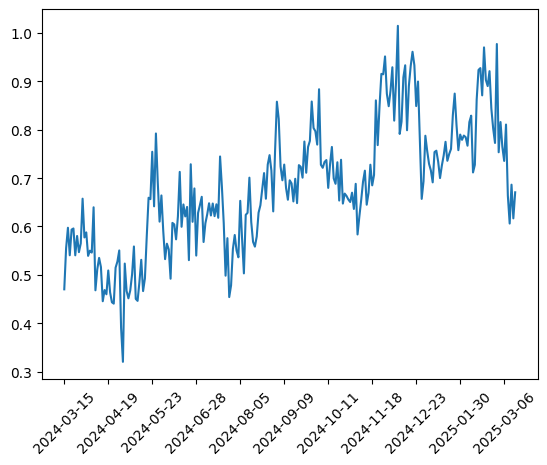

In [12]:
step = len(dates) // 10
plt.plot(dates, ivs)
plt.xticks(ticks=range(0, len(dates), step), labels=dates[::step], rotation=45)
plt.show()

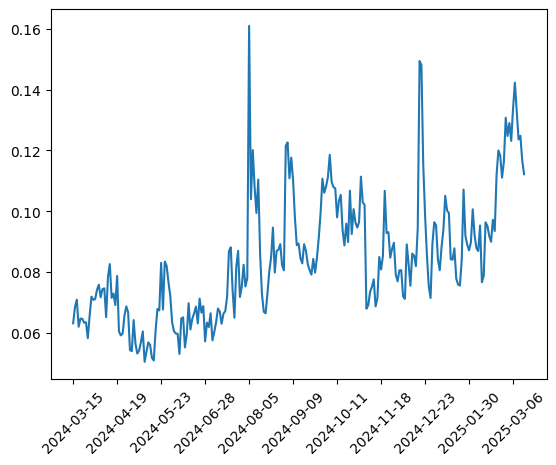

In [15]:
# put iv
step = len(dates) // 10
plt.plot(dates, ivs)
plt.xticks(ticks=range(0, len(dates), step), labels=dates[::step], rotation=45)
plt.show()

### We are going to remake the delta skew and normalized delta skew time series above

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import time
import numpy as np

from calc_engine.volatility.iv_calc import ImpliedVolatility
from data.data_processor.data_processor import MarketPriceProcessor, VolatilityProcessor
from calc_engine.greeks.analytical_greeks import AnalyticalDelta
from data.price_data import process_price_data
from data.option_data.process_option_chain import OptionFactory
from utils import date_utils
from utils.util_funcs import get_stock_price

In [ ]:
ticker = 'SPY'
close_date = '2024-03-15'
option_exp = '1M'
S = get_stock_price(ticker, close_date)

market_proc = MarketPriceProcessor(ticker, close_date)

start = '2024-03-15'
end = "2024-04-15"

exp = market_proc.option_call_graph.get_expirations_from_int(option_exp)
dte = market_proc.option_call_graph.get_dte_from_str(exp)

strikes, prices = zip(*market_proc.put_call_price_skew(S, 450, 550, exp))

In [ ]:
def delta_skew(put_delta, call_delta, ticker, start, end, option_exp = '1M'):
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]
    skew_list = []
    for close_date in common_dates:

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]
        min_strike, max_strike = S*.9, S*1.1
        
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp = market_proc.option_call_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_call_graph.get_dte_from_str(exp)/252

        strikes, prices = zip(*market_proc.put_call_price_skew(S, min_strike, max_strike, exp))
        strikes, prices = np.array(strikes), np.array(prices)
        #print(f"put indices: {np.where(strikes < S)[0]}")
        #print(f"prices: {prices}")
        #strikes, ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, prices, strikes, dte))
        call_strikes, call_ivs = zip(*VolatilityProcessor().otm_call_ivs(S, prices, strikes, dte))
        put_strikes, put_ivs = zip(*VolatilityProcessor().otm_put_ivs(S, prices, strikes, dte))
        call_ivs, put_ivs = np.array(call_ivs), np.array(put_ivs)
        #print(f"len ivs: {len(ivs)}")
        #print(f"len strikes: {len(strikes)}")
        call_deltas = AnalyticalDelta().calculate(S, call_strikes, dte, call_ivs, otype='call')
        put_deltas = AnalyticalDelta().calculate(S, put_strikes, dte, put_ivs, otype='put')
        call_idx = np.abs(call_deltas - call_delta).argmin()
        call_delta_iv = call_ivs[call_idx]
        print(f"call deltas: {call_deltas}")
        #print(f"call strikes: {call_strikes}")
        print(f"put deltas: {put_deltas}")
        put_idx = np.abs(put_deltas - put_delta).argmin()
        put_delta_iv = put_ivs[put_idx]
        #print(f"put strikes: {put_strikes}")
        #plt.plot(call_strikes, call_deltas)
        #plt.show()
        skew = put_delta_iv - call_delta_iv
        print('-'*100)
        print(f"put delta iv: {put_delta_iv}")
        print(f"call delta iv: {call_delta_iv}")
        print(f"skew: {skew}")
        skew_list.append((close_date, skew))
    return skew_list

def normalized_delta_skew(put_delta, call_delta, ticker, start, end, option_exp = '1M'):
    close_dates = date_utils.option_close_date_range(start, end)
    S_list, S_dates = process_price_data.get_close_prices(ticker, start, end)
    common_dates = [date for date in close_dates if date in S_dates]
    skew_list = []
    for close_date in common_dates:

        S_index = np.where(S_dates == close_date)[0][0]
        S = S_list[S_index]
        min_strike, max_strike = S*.9, S*1.1
        
        market_proc = MarketPriceProcessor(ticker, close_date)

        exp = market_proc.option_call_graph.get_expirations_from_str(option_exp)
        dte = market_proc.option_call_graph.get_dte_from_str(exp)/252

        strikes, prices = zip(*market_proc.put_call_price_skew(S, min_strike, max_strike, exp))
        strikes, prices = np.array(strikes), np.array(prices)
        #print(f"put indices: {np.where(strikes < S)[0]}")
        #print(f"prices: {prices}")
        #strikes, ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, prices, strikes, dte))
        call_strikes, call_ivs = zip(*VolatilityProcessor().otm_call_ivs(S, prices, strikes, dte))
        put_strikes, put_ivs = zip(*VolatilityProcessor().otm_put_ivs(S, prices, strikes, dte))
        call_ivs, put_ivs = np.array(call_ivs), np.array(put_ivs)
        #print(f"len ivs: {len(ivs)}")
        #print(f"len strikes: {len(strikes)}")
        call_deltas = AnalyticalDelta().calculate(S, call_strikes, dte, call_ivs, otype='call')
        put_deltas = AnalyticalDelta().calculate(S, put_strikes, dte, put_ivs, otype='put')
        call_idx = np.abs(call_deltas - call_delta).argmin()
        call_delta_iv = call_ivs[call_idx]
        print(f"call deltas: {call_deltas}")
        #print(f"call strikes: {call_strikes}")
        print(f"put deltas: {put_deltas}")
        put_idx = np.abs(put_deltas - put_delta).argmin()
        put_delta_iv = put_ivs[put_idx]
        #print(f"put strikes: {put_strikes}")
        #plt.plot(call_strikes, call_deltas)
        #plt.show()
        call_delta_atm_idx = np.abs(call_deltas - .5).argmin()
        call_delta_atm_iv = call_ivs[call_delta_atm_idx]

        put_delta_atm_idx = np.abs(put_deltas - (-.5))
        put_delta_atm_iv = put_ivs[put_delta_atm_idx]

        print(f'-'*100)
        print(f"atm call delta iv: {call_delta_atm_iv}")
        print(f"atm put delta iv: {put_delta_atm_iv}")
        skew = (put_delta_iv - call_delta_iv) / ((put_delta_atm_iv + call_delta_atm_iv)/2)

        print('-'*100)
        print(f"put delta iv: {put_delta_iv}")
        print(f"call delta iv: {call_delta_iv}")
        print(f"atm iv: {(call_delta_atm_iv + put_delta_atm_iv)/2}")
        print(f"skew: {skew}")
        skew_list.append((close_date, skew))

    return skew_list

normalized_delta_skew(-.25, .25, ticker, start, end)

# Stuff from Flash Cards
### To Dos (try to implement flash cards first)
##### 1. Skew Using Implied Rates
##### 2. Densities
## Skew Implied Forwards
##### We need to make it so if iv < .05 get rid of it.

##### Skew Arb Bounds to add
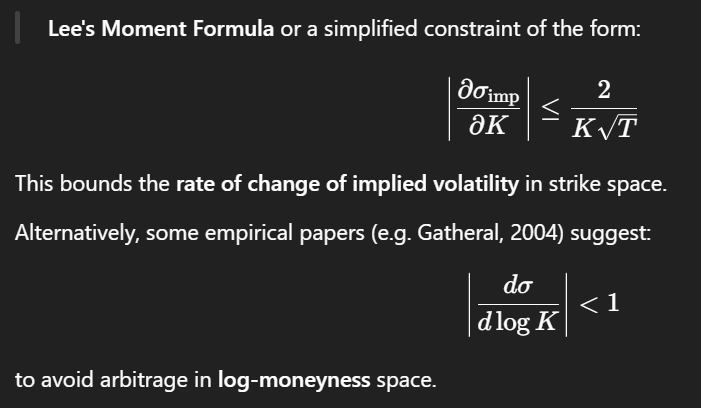
##### Note the below is from emanuel dermans lec but not sure if its log strike or not
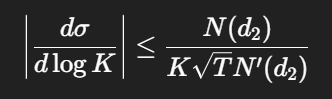

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from data.data_processor.data_processor import MarketPriceProcessor, VolatilityProcessor
from utils.util_funcs import get_stock_price
from calc_engine.volatility.iv_calc import ImpliedVolatility
from calc_engine.calibration.put_call_parity import implied_rate
from calc_engine.time_series import gvv
from calc_engine.volatility import point_estimate_models
from utils import date_utils
from data.price_data import process_price_data

In [ ]:
bad_exp = {"2025-04-02": ['2025-07-18', '2025-07-31', '2025-06-30', '2025-04-04']}

In [4]:
ticker = "SPY"
close_date = "2025-06-02"
S = get_stock_price(ticker, close_date)
print(f"S: {S}")
moneyness = .1
min_strike = S*(1-moneyness)
max_strike = S*(1+moneyness)
exp = '2025-06-13'

market_processor = MarketPriceProcessor(ticker, close_date)
print(market_processor.option_call_graph.get_expirations())
dte = market_processor.option_call_graph.get_dte_from_str(exp)/365
call_data = market_processor.all_calls(min_strike, max_strike, exp, steps=1)
put_data = market_processor.all_puts(min_strike, max_strike, exp, steps=1)

otm_strikes, otm_prices = zip(*market_processor.put_call_price_skew(S, min_strike, max_strike, exp, steps = 5))

strikes, ivs = zip(*VolatilityProcessor().equal_put_call_skew(S, call_data, put_data, dte))
strikes, ivs = np.array(strikes), np.array(ivs)
otm_strikes, otm_ivs = zip(*VolatilityProcessor().otm_put_call_skew(S, otm_prices, otm_strikes, dte))

S: 590.9629516601562
dict_keys(['2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05', '2025-06-06', '2025-06-09', '2025-06-10', '2025-06-11', '2025-06-12', '2025-06-13', '2025-06-20', '2025-06-27', '2025-06-30', '2025-07-03', '2025-07-11', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17'])


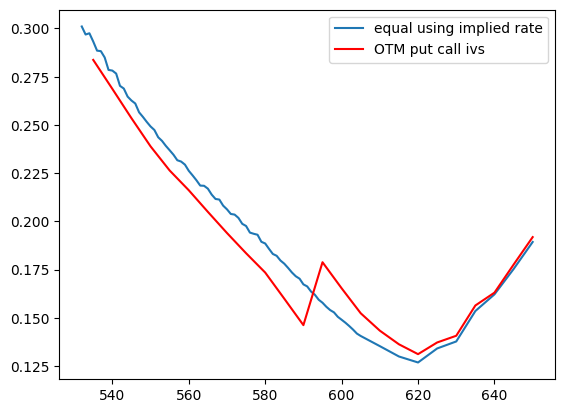

In [5]:
plt.plot(strikes, ivs, label="equal using implied rate")
plt.plot(otm_strikes, otm_ivs, 'r', label="OTM put call ivs")
plt.legend()
plt.show()

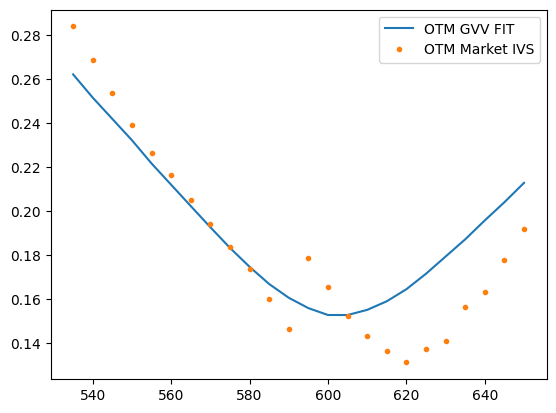

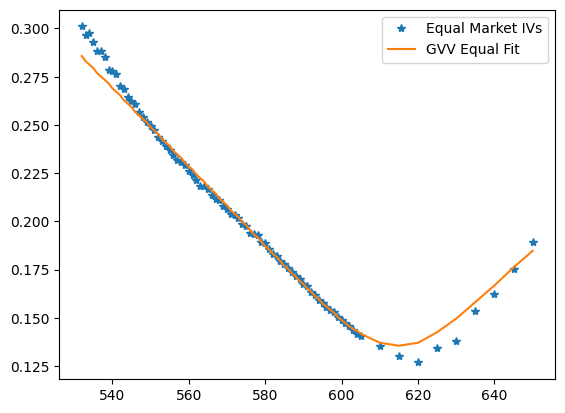

In [6]:
gvv_model = point_estimate_models.GVV()

strikes, ivs = np.array(strikes), np.array(ivs)
otm_strikes, otm_ivs = np.array(otm_strikes), np.array(otm_ivs)

gvv_otm_ivs = gvv_model.skew(S, otm_strikes, dte, otm_ivs, method = 'root finder')
gvv_equal_ivs = gvv_model.skew(S, strikes, dte, ivs, method = 'root finder')
plt.plot(otm_strikes, gvv_otm_ivs, label="OTM GVV FIT")
plt.plot(otm_strikes, otm_ivs, '.', label="OTM Market IVS")
plt.legend()
plt.show()
plt.plot(strikes, ivs, '*', label="Equal Market IVs")
plt.plot(strikes, gvv_equal_ivs, label='GVV Equal Fit')
plt.legend()
plt.show()

##### Above is cool but we probably wont use it or the code in the term_structure.py
##### I need to do more research on termstructures and understand why the put term structure is upward sloping and the call term structure is inverted.
##### For atm term structure we can probably take the average of put and call ivs, think about the VIX calculation

In [37]:
[market_processor.atm_option(S, exp)[1] for exp in exps]

[7.4, 11.635, 14.39, 23.244999999999997, 28.575, 33.230000000000004]

### 10-day Z-score Vix 3m and 1m

$^VIX9M: possibly delisted; no timezone found


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


<Axes: xlabel='Date'>

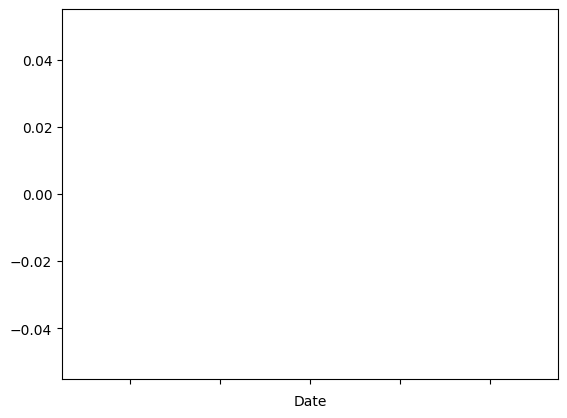

In [32]:
import yfinance as yf

tickers = [
    "^VIX",
    "^VIX3M", "^VIX6M",
    "^VIXMAR","^VIXJUL","^VIXAUG",  # add whichever monthly ones exist
    "^SPVIX2ME","^SPVIX3ME","^SPVIX4MT","^SPVIX6MT",
    "^SKEW","^VVIX"
]

# Ticker for 3‑Month VIX Futures Index
ticker = yf.Ticker("^vix9m")

# Download historical OHLCV data
df = ticker.history(period='max')

print(df)
df["Close"].plot()

In [ ]:
import yfinance as yf

tickers = ["^VIX", "^VIX3M", "^VIX6M", "^VVIX", "^SKEW"]

data = yf.download(tickers, period="max")
print(data["Close"].tail())

[*********************100%***********************]  8 of 8 completed

3 Failed downloads:
['^VIX9M', '^VIX1M']: YFTzMissingError('possibly delisted; no timezone found')
['^VIX1Y']: YFInvalidPeriodError("^VIX1Y: Period 'max' is invalid, must be of the format 1d, 5d, etc.")


Ticker           ^SKEW       ^VIX  ^VIX1M  ^VIX1Y     ^VIX3M     ^VIX6M  \
Date                                                                      
2025-07-07  137.960007  17.790001     NaN     NaN  20.209999  21.610001   
2025-07-08  140.800003  16.809999     NaN     NaN  19.580000  21.110001   
2025-07-09  141.750000  15.940000     NaN     NaN  19.020000  20.719999   
2025-07-10  143.320007  15.780000     NaN     NaN  18.920000  20.680000   
2025-07-11  144.960007  16.400000     NaN     NaN  19.370001  21.090000   

Ticker      ^VIX9M      ^VVIX  
Date                           
2025-07-07     NaN  96.300003  
2025-07-08     NaN  91.309998  
2025-07-09     NaN  91.760002  
2025-07-10     NaN  90.940002  
2025-07-11     NaN  93.529999  


In [33]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json
import datetime

# Step 1: Get HTML content from VIXCentral
url = "https://vixcentral.com/historical/?days=365"
res = requests.get(url)
soup = BeautifulSoup(res.content, "html.parser")

# Step 2: Extract JSON from <script> tag
script_text = [s.text for s in soup.find_all("script") if "historicalChartData" in s.text][0]
json_str = script_text.split("var historicalChartData = ")[1].split(";\n")[0]

# Step 3: Load JSON
data = json.loads(json_str)

# Step 4: Convert to DataFrame
records = []
for row in data:
    date_str = row['date']
    for contract in row['data']:
        records.append({
            'date': pd.to_datetime(date_str),
            'days_to_expiration': contract['x'],
            'vix_price': contract['y']
        })

df = pd.DataFrame(records)
df = df.sort_values(by=["date", "days_to_expiration"])
df.head()

ConnectionError: HTTPSConnectionPool(host='vixcentral.com', port=443): Max retries exceeded with url: /historical/?days=365 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000029F10901400>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))